# Imports

In [173]:
import os
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, AvgPool2D
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import glob
from IPython.display import Image
%matplotlib inline

# Data Preparation

In [174]:
NUM_CLASSES = 10
img_rows, img_cols = 28, 28
PATH_TRAIN = "../Image_Classification/digit-recognizer/dataset/train.csv"
PATH_TEST = "../Image_Classification/digit-recognizer/dataset/test.csv"

def load_dataset(PATH_TRAIN, PATH_TEST):
    """
    Args: 
        PATH_TRAIN - training file, PATH_TEST - testing file
    Returns:
      Train dataset, test dataset
    """
    print("Loading training/testing dataset..")
    digit_train = np.loadtxt(PATH_TRAIN, skiprows=1, delimiter=',')
    digit_test = np.loadtxt(PATH_TEST, skiprows=1, delimiter=',')
    
    print("Shape of train file = ", digit_train.shape)
    print("Shape of test file = ", digit_test.shape)
    
    return digit_train, digit_test

def input_train_datasets(digit_train):
    """
    Args: 
        digit_train - training datset
    Returns:
      Reshaped Train dataset, eval dataset(10%)
    """
    # input image dimensions with channels last
    y = digit_train[:, 0]
    print("Total number of records in train file = ", len(y))
    out_y = keras.utils.to_categorical(y, NUM_CLASSES)
    
    x = digit_train[:,1:]
    out_x = x.reshape(-1, img_rows, img_cols, 1)
    out_x /= 255
    print("Re-shaped train file = ", out_x.shape)
    
    # the data, split between train and test sets
    x_train, x_val, y_train, y_val = train_test_split(out_x, out_y, test_size = 0.1, random_state=2)

    return x_train, x_val, y_train, y_val

def input_test_datasets(digit_test):
    """
    Args: 
        digit_test - test datset
    Returns:
      Reshaped test dataset
    """
    print("Total number of records in test file = ", len(digit_test))
    test = digit_test / 255
    test = test.reshape(-1,28,28,1)
    print("Re-shaped test file = ", test.shape)
    
    return test

print("Setup Complete")

Setup Complete


# Model Building
Creating a `Sequential` model named `digit_model`

In [175]:
def create_model():
    """
    Args: 
    Returns:
      Built model
    """

    digit_model = Sequential()
    
    #Add layers
    digit_model.add(Conv2D(32, kernel_size=(5,5), activation = 'relu', padding = 'Same', input_shape = (img_rows, img_cols,1)))
    digit_model.add(Conv2D(32, kernel_size=(5,5), activation = 'relu', padding = 'Same'))
    digit_model.add(AvgPool2D(pool_size=(2,2)))
    digit_model.add(Dropout(0.25))

    digit_model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', padding = 'Same'))
    digit_model.add(AvgPool2D(pool_size=(2,2)))
    digit_model.add(Dropout(0.25))
    
    digit_model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', padding = 'Same'))
    digit_model.add(AvgPool2D(pool_size=(2,2)))   
    digit_model.add(Dropout(0.25))
    
    digit_model.add(Flatten())
    digit_model.add(Dense(128, activation='relu'))
    digit_model.add(Dropout(0.5))
    digit_model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    
    #optimizer 
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
    #Complile Model
    digit_model.compile(loss='categorical_crossentropy',
                        optimizer = optimizer,
                        metrics=['accuracy'])            
    
    return digit_model



digit_train, digit_test = load_dataset(PATH_TRAIN,PATH_TEST)
x_train, x_val, y_train, y_val = input_train_datasets(digit_train)

digit_model=create_model()
batch_size = 60
epochs = 30

#defining callback params
csv_logger = CSVLogger('../Image_Classification/digit-recognizer/model/digit_train_hist.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
mcp_save = ModelCheckpoint('../Image_Classification/digit-recognizer/model/digit_model_wts.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    

datagen_train = ImageDataGenerator(width_shift_range=0.2,   
                                    height_shift_range=0.2,
                                    horizontal_flip=True)

# fit augmented image generator on data
print("Fitting augmented image generator on training data: x_train")
datagen_train.fit(x_train)

t0=time.time()
print("Starting to fit training data on built model..")
history = digit_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data = (x_val, y_val),
                    callbacks=[learning_rate_reduction, csv_logger])
    
t1=time.time()
print("Time took to fit the training data: {} secs".format(t1-t0))

#save the history if need to plot metrics later
# with open("../Image_Classification/digit-recognizer/model/ModelHistoryDict", 'wb') as file:
#     pickle.dump(history.history, file)
# print("Saved history data")

#save model for later use
digit_model.save('../Image_Classification/digit-recognizer/model/digit_model_test.model')



Loading training/testing dataset..
Shape of train file =  (42000, 785)
Shape of test file =  (28000, 784)
Total number of records in train file =  42000
Re-shaped train file =  (42000, 28, 28, 1)
Fit augmented image generator on training data: x_train
Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 161s 4ms/sample - loss: 0.3938 - acc: 0.8757 - val_loss: 0.0942 - val_acc: 0.9707
Epoch 2/30
37800/37800 [==============================] - 154s 4ms/sample - loss: 0.1300 - acc: 0.9622 - val_loss: 0.0692 - val_acc: 0.9802
Epoch 3/30
37800/37800 [==============================] - 150s 4ms/sample - loss: 0.0905 - acc: 0.9731 - val_loss: 0.0778 - val_acc: 0.9769
Epoch 4/30
37800/37800 [==============================] - 149s 4ms/sample - loss: 0.0763 - acc: 0.9780 - val_loss: 0.0551 - val_acc: 0.9843
Epoch 5/30
37800/37800 [==============================] - 154s 4ms/sample - loss: 0.0638 - acc: 0.9813 - val_loss: 0.0460 - val_acc: 0.9864

In [176]:
digit_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
average_pooling2d_54 (Averag (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
average_pooling2d_55 (Averag (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 7, 7, 64)          0         
__________

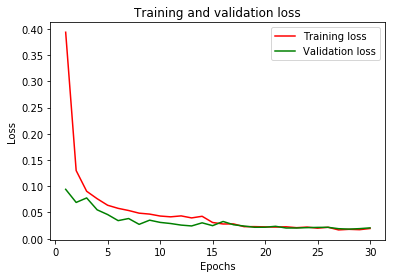

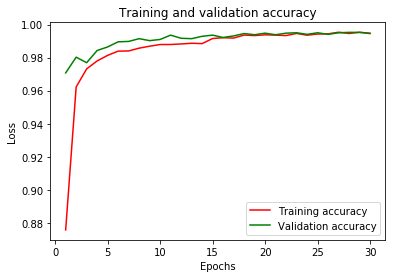

In [238]:
# visualization loss function
loss = digit_model.history.history['loss']
val_loss = digit_model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# visualization accuracy scores
acc = digit_model.history.history['acc']
val_acc = digit_model.history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [178]:
#predicting classes of x_val for model quality check
Y_pred = digit_model.predict(x_val)
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
print("Predicted classes shape: ", Y_pred_classes.shape)
Y_true = np.argmax(y_val, axis = 1) 
print("True classes shape: ", Y_true.shape)

Predicted classes shape:  (4200,)
True classes shape:  (4200,)


In [179]:
# calculate classification metrics
target_names = ["Class {}".format(i) for i in range(NUM_CLASSES)]
metric_report = classification_report(Y_true, Y_pred_classes, target_names=target_names)
print(metric_report)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       411
     Class 1       1.00      1.00      1.00       485
     Class 2       1.00      1.00      1.00       403
     Class 3       1.00      0.99      1.00       418
     Class 4       0.99      0.99      0.99       461
     Class 5       1.00      0.99      0.99       372
     Class 6       0.99      0.99      0.99       413
     Class 7       1.00      1.00      1.00       446
     Class 8       0.98      0.99      0.99       382
     Class 9       0.99      1.00      0.99       409

   micro avg       0.99      0.99      0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



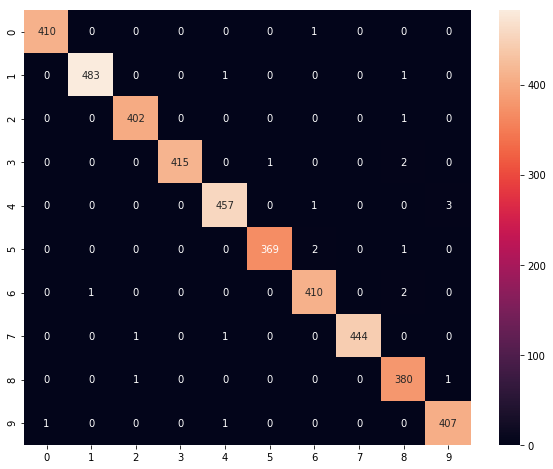

In [180]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")

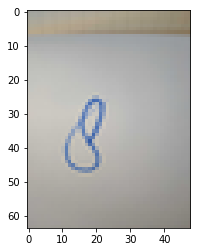

In [224]:
# Loading a sample hand written test image
from PIL import Image

img = Image.open('../Image_Classification/digit-recognizer/adhoc_test_files/test1_8.jpg')
img.thumbnail((64, 64), Image.ANTIALIAS)  # resizes image in-place
imgplot = plt.imshow(img)

In [184]:
# Test random hanwritten image of 8 in different styles
PATH_SMALL_TEST = "../Image_Classification/digit-recognizer/adhoc_test_files/"
path = os.path.realpath(PATH_SMALL_TEST)
fullpath = os.path.join(path, '*.jpg')
files = glob.glob(fullpath)
files = pd.DataFrame(files,columns=["Image_Name"])
files


,Image_Name
0,/Users/putatundaj/Desktop/Projects/Image_Class...
1,/Users/putatundaj/Desktop/Projects/Image_Class...
2,/Users/putatundaj/Desktop/Projects/Image_Class...


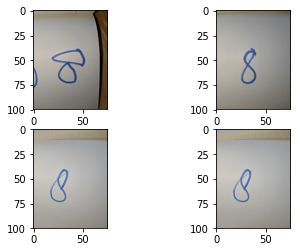

In [243]:
img_all=[]
for i in files["Image_Name"]:
    img1 = Image.open(i)
    img1.thumbnail((100, 100)) 
    img_all.append(img1)
    
f, axarr = plt.subplots(2,2)

axarr[0,0].imshow(img_all[0])
axarr[0,1].imshow(img_all[1])
axarr[1,0].imshow(img_all[2])
axarr[1,1].imshow(img_all[2])


In [244]:
test_image = []
for i in files['Image_Name']:
    img = image.load_img(i, target_size=(28,28), color_mode = "grayscale")
    img = image.img_to_array(img)
    print(img.shape)
    img/=255
    img = img.reshape(-1, 28, 28, 1)
    print("Re-shaped of test image: ",img.shape)
    prediction = digit_model.predict_classes(img)
    print("Predicted class of test image: ",prediction)
    print("\n")

(28, 28, 1)
Re-shaped of test image:  (1, 28, 28, 1)
Predicted class of test image:  [8]


(28, 28, 1)
Re-shaped of test image:  (1, 28, 28, 1)
Predicted class of test image:  [8]


(28, 28, 1)
Re-shaped of test image:  (1, 28, 28, 1)
Predicted class of test image:  [8]




In [221]:
# labeling the test file from kaggle
x_test= input_test_datasets(digit_test)

print("Evaluating and labeling test file...")
results = digit_model.predict(x_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,len(results)+1),name = "ImageId"),results],axis = 1)

Evaluating and labelling test file...


In [222]:
#writing to a csv file
submission.to_csv("submission_file_Digit_Sept25.csv",index=False)